# **Rubin's LSST host galaxy association**
#### This notebook measures the **Directional Light Radius** (DLR; Gupta et al. 2016) to associate transients to host-galaxies.

Tested on DP0.2 with simulated SNIa.

Author: Vincenzo Petrecca (vincenzo.petrecca@inaf.it)

## 00) Import commonly used packages and load the data

In [1]:
### Rubin-specific packages

import lsst.geom as geom
import lsst.sphgeom as sphgeom
import lsst.daf.base as dafBase
import lsst.afw.display as afwDisplay
from lsst.afw.image import MultibandExposure
import lsst.daf.butler as dafButler
from lsst.daf.butler import Butler
from lsst.rsp import get_tap_service, retrieve_query
service = get_tap_service()

### General python / astronomy packages

import time
import matplotlib.pyplot as plt
import pylab as pl
import numpy as np
import pandas as pd
import math
import gc
from matplotlib import container
import healpy as hp
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.wcs import WCS
import astropy.units as u
from astropy.time import Time
from astropy.table import Table
from astropy.io import fits
from astropy.io import ascii

%matplotlib inline 
pd.set_option('display.max_columns', None)

/tmp/ipykernel_11470/2134233444.py:11: DeprecationWarning: get_tap_service() is deprecated, use get_tap_service("tap")
  service = get_tap_service()


In [2]:
# This function come from the official Rubin DP0.2 Tutorial notebooks by the Community Science Team

def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # Get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # Clear the figure
    plt.close(fig)  # Close the figure
    gc.collect()    # Call the garbage collector

In [3]:
# This function come from the official Rubin DP0.2 Tutorial notebooks by the Community Science Team

def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [4]:
# Set up some plotting defaults:

params = {'axes.labelsize': 13,
          'font.size': 12,
          'legend.fontsize': 12,
          'xtick.major.width': 1.5,
          'xtick.minor.width': 1,
          'xtick.major.size': 6,
          'xtick.minor.size': 3,
          'xtick.direction': 'in',
          'xtick.top': True,
          'lines.linewidth': 1.5,
          'axes.linewidth': 1.5,
          'axes.labelweight': 1.5,
          'axes.titleweight': 1.5,
          'ytick.major.width': 1.5,
          'ytick.minor.width': 1,
          'ytick.major.size': 6,
          'ytick.minor.size': 3,
          'ytick.direction': 'in',
          'ytick.right': True,
          'figure.figsize': [8, 8],
          'figure.facecolor': 'White'
          }

plt.rcParams.update(params)

In [5]:
# Instantiate the Butler
config = 'dp02'
collection = '2.2i/runs/DP0.2'
butler = Butler(config, collections=collection)

#### Load a table of transients in a '.csv' file containing at least 'ra' and 'dec'

In [6]:
transient_sample = pd.read_csv('transient_sample_list.csv')
transient_sample

,transient_id,transient_ra,transient_dec
0,MS_9044_39,56.314348,-29.808301
1,MS_9171_91,54.992551,-30.359711
2,MS_9171_88,55.484950,-30.545025


## 01) Cone search around each transient to get information on host-galaxy candidates

N.B. the query might be long. We suggest to run it just one time and save the results into a table (see next cell)

In [7]:
transient_ra = np.asarray(transient_sample['transient_ra'])
transient_dec = np.asarray(transient_sample['transient_dec'])

# Define empty lists
candidates_tract = []
candidates_patch = []
candidates_objectId = []
candidates_ra = []
candidates_dec = []
candidates_shape_xx = [] 
candidates_shape_xy = []
candidates_shape_yy = []
candidates_kron = []
candidates_mag = []
candidates_magerr = []
candidates_extendedness = [] 
candidates_primary_flag = []

for source in range(transient_sample.shape[0]):
    
    # ADQL Cone Search to find candidate host galaxies for each transient
    results = service.search("SELECT coord_ra, coord_dec, tract, patch, objectId, "
                         "shape_xx, shape_xy, shape_yy, i_kronRad, "
                         "scisql_nanojanskyToAbMag(i_kronFlux) AS i_kronMag, "
                         "scisql_nanojanskyToAbMagSigma(i_kronFlux, i_kronFluxErr) AS i_kronMagErr, "
                         "detect_isPrimary, refExtendedness "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', " 
                         +str(transient_ra[source])+", "+str(transient_dec[source])+", 0.0083)) = 1 " #  i.e., 30 arcsec in degrees
                         "AND shape_flag = 0 AND xy_flag = 0 AND i_kronFlux_flag = 0 AND detect_isPrimary = 1")
    results = results.to_table().to_pandas()
    
    # Retrieve the corresponding tracts and ObjectIds
    candidate_tract = results['tract'].tolist()
    candidate_patch = results['tract'].tolist()
    candidate_objectId = results['objectId'].tolist()
    candidate_ra = results['coord_ra'].tolist()
    candidate_dec = results['coord_dec'].tolist()
    candidate_shape_xx = results['shape_xx'].tolist()
    candidate_shape_xy = results['shape_xy'].tolist()
    candidate_shape_yy = results['shape_yy'].tolist()
    candidate_kron = results['i_kronRad'].tolist()
    candidate_mag = results['i_kronMag'].tolist()
    candidate_magerr = results['i_kronMagErr'].tolist()
    candidate_extendedness = results['refExtendedness'].tolist()
    candidate_primary_flag = results['detect_isPrimary'].tolist()
    
    # Append to the final list
    candidates_tract.append(candidate_tract)
    candidates_patch.append(candidate_patch)
    candidates_objectId.append(candidate_objectId)
    candidates_ra.append(candidate_ra)
    candidates_dec.append(candidate_dec)
    candidates_shape_xx.append(candidate_shape_xx)
    candidates_shape_xy.append(candidate_shape_xy)
    candidates_shape_yy.append(candidate_shape_yy)
    candidates_kron.append(candidate_kron)
    candidates_mag.append(candidate_mag)
    candidates_magerr.append(candidate_magerr)
    candidates_extendedness.append(candidate_extendedness)
    candidates_primary_flag.append(candidate_primary_flag)

In [8]:
# Build a DataFrame with all che candidates

dict_candidates = {'tract':candidates_tract, 'patch':candidates_patch, 'objectId':candidates_objectId,
                  'ra':candidates_ra, 'dec':candidates_dec, 'mag':candidates_mag, 'magerr':candidates_magerr, 
                   'shape_xx':candidates_shape_xx, 'shape_xy':candidates_shape_xy, 'shape_yy':candidates_shape_yy,
                  'kron_radius':candidates_kron, 'extendedness':candidates_extendedness, 'primary_flag':candidates_primary_flag}

df_candidates = pd.DataFrame(dict_candidates)

In [9]:
# Save the table for future uses

df_candidates.to_parquet('all_host_candidates.parquet')

In [10]:
# Merge the transient sample and the candidates table into a unique DataFrame

DF = pd.concat([transient_sample, df_candidates], axis=1)

# Save into a table for future uses
DF.to_parquet('DF_all.parquet')

## 02) Script for host-galaxy association

Read the file with the candidates and all the transients from part 1)

In [11]:
DF = pd.read_parquet('DF_all.parquet')

DF.head(3)

,transient_id,transient_ra,transient_dec,tract,patch,objectId,ra,dec,mag,magerr,shape_xx,shape_xy,shape_yy,kron_radius,extendedness,primary_flag
0,MS_9044_39,56.314348,-29.808301,"[4639, 4639, 4639, 4639, 4639, 4639, 4639, 463...","[4639, 4639, 4639, 4639, 4639, 4639, 4639, 463...","[1999844525157159975, 1999844525157159977, 199...","[56.3119191, 56.3132351, 56.3132817, 56.309142...","[-29.8156104, -29.8155109, -29.8163098, -29.80...","[23.128902471133166, 23.891615438045704, 25.10...","[0.036135549007907976, 0.06554885490137115, 0....","[5.8245264, 4.385329, 7.376096, 4.718836, 6.22...","[-0.2992058, -0.4187095, -0.3598771, -0.736171...","[4.6514046, 5.1509969, 4.8455968, 5.5938542, 5...","[4.5684099197387695, 4.134990215301514, 4.9967...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru..."
1,MS_9171_91,54.992551,-30.359711,"[4638, 4638, 4638, 4638, 4638, 4638, 4638, 463...","[4638, 4638, 4638, 4638, 4638, 4638, 4638, 463...","[1999272779110733091, 1999281575203702122, 199...","[54.9976125, 54.9833381, 54.9898496, 54.992032...","[-30.3616684, -30.3619761, -30.3525475, -30.35...","[24.92544422515042, 25.587094727835144, 24.300...","[0.275140484104272, 0.21573065628703925, 0.065...","[4.5871808, 2.1084668, 4.4050799, 3.5224303, 4...","[0.4084061, 0.2713426, -0.2875405, 0.2327171, ...","[4.0576082, 2.5924701, 3.1446241, 2.4967756, 4...","[6.549449920654297, 2.8076300621032715, 2.7817...","[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...","[True, True, True, True, True, True, True, Tru..."
2,MS_9171_88,55.484950,-30.545025,"[4639, 4639, 4639, 4639, 4639, 4639, 4639, 463...","[4639, 4639, 4639, 4639, 4639, 4639, 4639, 463...","[1999686195482725318, 1999686195482725302, 199...","[55.4901116, 55.4911282, 55.4797604, 55.490869...","[-30.5431981, -30.543714, -30.5411299, -30.542...","[23.083256401284096, 23.061606117023743, 22.69...","[0.0808842835575548, 0.08531882603574505, 0.07...","[6.3815616, 16.2174352, 16.0717019, 7.4397679,...","[4.6181936, -5.129981, 1.6411765, -2.5870651, ...","[14.732364, 7.2043934, 12.8376121, 4.7770694, ...","[10.611499786376953, 11.410300254821777, 13.53...","[1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, ...","[True, True, True, True, True, True, True, Tru..."


In [12]:
# Define the list of transient IDs and coordinates
ids = np.asarray(DF['transient_id'])
ra = np.asarray(DF['transient_ra'])
dec = np.asarray(DF['transient_dec'])

# Import host galaxy properties from object table
kron_radius = np.asarray(DF['kron_radius']*2.5*0.21) # Take 2.5 times the Kron radius and convert in arcseconds
Ixx = np.asarray(DF['shape_xx']*0.21*0.21) # Convert from pixel to arcseconds
Iyy = np.asarray(DF['shape_yy']*0.21*0.21)
Ixy = np.asarray(DF['shape_xy']*0.21*0.21)
ra_gal = np.asarray(DF['ra'])
dec_gal = np.asarray(DF['dec'])
gal_id = np.asarray(DF['objectId'])
mag = np.asarray(DF['mag'])
magerr = np.asarray(DF['magerr'])

#### Measure the DLR and rank galaxies according to:
- best_id = minimum DLR
- best_id2 = minimum angular separation
- best_id3 = minimum angular separation / Kron radius

In [13]:
# Define empty lists to store values

best_id = []
best_id2 = []
best_id3 = []
best_dlr = []
best_sep = []
best_gal_ra = []
best_gal_dec = []
best_mag = []
best_kron = []
best_C = []
best_r_ab = []

scaled_dlr_all = []
sep_all = []
phi_all = []
alpha_all = []
theta_all = []
C_all = []
r_ab_all = []

hostless = []

#for i in range(10):
for i in range(len(ids)):
    # Coordinates of the galaxies and angular separation from the transient
    transient_coords = SkyCoord(ra[i]*u.degree,dec[i]*u.degree)
    scaled_dlr = []
    # Optional lists
    C_list = []
    phi_list = []
    alpha_list = []
    theta_list = []
    r_ab_list = []
    sep_list = []
    kron_list = []
    dlr_list = []
    mag_list = []
    for j in range(len(Ixx[i])):
        gal_coords = SkyCoord(ra_gal[i][j]*u.degree, dec_gal[i][j]*u.degree)
        sep = gal_coords.separation(transient_coords).arcsec
        # Stokes parameters of the galaxy
        U = Ixy[i][j]
        Q = Ixx[i][j] - Iyy[i][j]
        if np.isnan(U) or np.isnan(Q): # reject eventual bad objects
            scaled_dlr.append(np.nan)
            phi_list.append(np.nan)
            alpha_list.append(np.nan)
            theta_list.append(np.nan)
            r_ab_list.append(np.nan)
            sep_list.append(np.nan)
            kron_list.append(np.nan)
            dlr_list.append(np.nan)
            mag_list.append(np.nan)
            C_list.append(np.nan)
            continue
        else:
            pass
        
        # Kron radius (used as extimate of the galaxy's semi-major axis)
        kron = kron_radius[i][j]
        
        # Position angle of the galaxy relative to the celestial north
        phi = 0.5*math.atan(U/Q)
        if phi < 0:
            phi = math.pi + phi
            
        # Aspect ratio of the galaxy
        k = Q**2 + U**2
        r_ab = (1+k+2*math.sqrt(k))/(1-k)
        
        # Position angle of the transient relative to the host galaxy
        alpha = gal_coords.position_angle(transient_coords).radian
        
        # Angle subtended by the galactic semi-major axis and the vector connecting the transient to the galactic center
        beta = abs(alpha - phi)
        if alpha >= phi:
            if alpha >= (phi+math.pi):
                theta = 2*math.pi - beta
            else:
                theta = math.pi - beta
        if alpha < phi:
            theta = beta
        
        ## Directional Light Radius
        r1 = r_ab*math.sin(theta)
        r2 = math.cos(theta)
        r3 = math.sqrt((r1**2) + (r2)**2)
        dlr = kron/r3
        
        
        # Scaled Directional Light Radius (using angular separation in arcseconds)
        scaled = sep/dlr
        scaled_dlr.append(scaled)
        # Optional lists
        C_list.append(r3)
        phi_list.append(phi)
        alpha_list.append(alpha)
        theta_list.append(theta)
        r_ab_list.append(r_ab)
        sep_list.append(sep)
        kron_list.append(kron)
        dlr_list.append(dlr)
        mag_list.append(mag[i][j])
        
        #  Define a normalized angular separation        
        sep_norm = ((np.asarray(sep_list))/(np.asarray(kron_list)))
    
    for ind in range(len(scaled_dlr)):
        # Attitional cuts (optional)
        if mag_list[ind] >= 24.5 or np.isnan(mag_list[ind]) or kron_list[ind] >= 7.5:
            scaled_dlr[ind] += 1000 # Add a penalization to these candidates
        if (mag_list[ind] > 23.5 and kron_list[ind] > 0.8):
            scaled_dlr[ind] += 1000 # Add a penalization to these candidates
            
    # Append results for each transient
    try:
        scaled_dlr_all.append(scaled_dlr)   
        best = np.nanargmin(scaled_dlr)
        best2 = np.nanargmin(sep_list) # Find the best candidate using angular separation only
        best3 = np.nanargmin(sep_norm) # Find the best candidate using angular separation normalized with the weighted Kron radius
        

        # Check if host-galaxy is reliable and define host-less transients
        if np.nanmin(scaled_dlr) > 4:
            best_id.append(np.nan)
            best_id2.append(gal_id[i][best2])
            best_id3.append(gal_id[i][best3])
            best_sep.append(sep_list[best])
            best_dlr.append(np.nanmin(scaled_dlr))
            best_gal_ra.append(ra_gal[i][best])
            best_gal_dec.append(dec_gal[i][best])
            best_mag.append(mag_list[best])
            best_kron.append(kron_list[best])
            best_C.append(C_list[best])
            best_r_ab.append(r_ab_list[best])
            
            hostless.append(i) # Take track of these transients
        else:
            best_id.append(gal_id[i][best])
            best_id2.append(gal_id[i][best2])
            best_id3.append(gal_id[i][best3])
            best_sep.append(sep_list[best])
            best_dlr.append(np.nanmin(scaled_dlr))
            best_gal_ra.append(ra_gal[i][best])
            best_gal_dec.append(dec_gal[i][best])
            best_mag.append(mag_list[best])
            best_kron.append(kron_list[best])
            best_C.append(C_list[best])
            best_r_ab.append(r_ab_list[best])
    except:
        best_id.append(np.nan)
        best_id2.append(np.nan)
        best_id3.append(np.nan)
        best_dlr.append(np.nan)
        best_sep.append(np.nan)
        best_gal_ra.append(np.nan)
        best_gal_dec.append(np.nan)
        best_mag.append(np.nan)
        best_kron.append(np.nan)
        best_C.append(np.nan)
        best_r_ab.append(np.nan)
    
    sep_all.append(sep_list)
    phi_all.append(phi_list)
    alpha_all.append(alpha_list)
    theta_all.append(theta_list)
    C_all.append(C_list)
    r_ab_all.append(r_ab_list)  

## 04) Explore single cases

In [14]:
# Select a transient from your list

s = 1

order = np.argsort(scaled_dlr_all[s])

In [15]:
dict = {'gal_id':gal_id[s][order],'separation':np.asarray(sep_all[s])[order],
        'sep/kron':((np.asarray(sep_all[s])[order])/(kron_radius[s][order])),
        'DLR':np.asarray(scaled_dlr_all[s])[order],
        'gal_ra':ra_gal[s][order],
       'gal_dec':dec_gal[s][order],'kron_radius':kron_radius[s][order],
        'mag_kron_i':mag[s][order],'mag_kron_i_err':DF['magerr'][s][order],
       'Ixx':Ixx[s][order],'Iyy':Iyy[s][order],'Ixy':Ixy[s][order], 'ab':np.asarray(r_ab_all[s])[order],
       'C':np.asarray(C_all[s])[order],'phi':np.asarray(phi_all[s])[order],
        'alpha':np.asarray(alpha_all[s])[order],'theta':np.asarray(theta_all[s])[order],
       'primary_flag': DF['primary_flag'][s][order]}

In [16]:
ss = pd.DataFrame(dict)

print(ids[s])

MS_9171_91


In [17]:
# Print the first 10 candidates

ss.head(10)

,gal_id,separation,sep/kron,DLR,gal_ra,gal_dec,kron_radius,mag_kron_i,mag_kron_i_err,Ixx,Iyy,Ixy,ab,C,phi,alpha,theta,primary_flag
0,1999272779110710187,3.357852,0.812905,0.972690,54.991834,-30.360409,4.130684,18.826321,0.001252,0.796641,0.525016,0.271386,2.246580,1.196561,0.392478,0.725207,2.808864,True
1,1999272779110680018,16.796388,2.820815,4.500610,54.997754,-30.360981,5.954445,23.447352,0.121991,0.701094,0.508397,0.124567,1.595562,1.595500,0.286935,4.988052,1.582068,True
2,1999272779110711023,22.732168,7.759145,8.408656,54.997923,-30.355422,2.929726,20.864236,0.005656,0.534017,0.649277,-0.096763,1.354304,1.083709,0.349190,3.965721,2.666654,True
3,1999272779110710186,14.528699,10.637885,10.642880,54.990947,-30.355920,1.365751,19.540390,0.000863,0.140292,0.139145,0.000262,1.002355,1.000470,0.112402,2.791383,0.462611,True
4,1999272779110710071,22.808154,10.475374,11.312801,54.999350,-30.362103,2.177312,22.804087,0.024424,0.274865,0.272308,0.043621,1.091384,1.079942,0.756125,5.099665,1.939645,True
5,1999272779110710067,28.792309,13.548047,14.091424,55.001245,-30.362485,2.125200,21.206028,0.005502,0.210769,0.233010,0.000030,1.045494,1.040107,3.140928,5.066570,1.215950,True
6,1999272779110709616,27.653655,13.557333,18.317776,54.999455,-30.364561,2.039756,22.809349,0.023129,0.484378,0.236684,-0.094087,1.720948,1.351134,2.960084,5.395763,0.705913,True
7,1999272779110711144,29.278043,21.337177,21.337224,54.993465,-30.351616,1.372161,19.839906,0.001136,0.137365,0.135576,0.000261,1.003624,1.000002,0.072447,3.238697,3.116935,True
8,1999272779110710188,0.023437,0.015750,1000.015812,54.992544,-30.359711,1.488029,24.468234,0.078414,0.151086,0.152531,-0.002738,1.006212,1.003914,0.542589,1.458920,2.225262,True
9,1999272779110710216,5.097411,2.157021,1002.393830,54.993232,-30.358422,2.363172,24.470337,0.123395,0.242609,0.335443,0.057682,1.245412,1.109785,2.863611,3.568998,2.436205,True


#### Produce a cutout around the transient

In [18]:
# Get the coordinates
transient_ra, transient_dec = DF['transient_ra'].values[s]*u.deg, DF['transient_dec'].values[s]*u.deg
targ_coord = SkyCoord(ra=transient_ra,dec=transient_dec)

In [19]:
pixelization = sphgeom.HtmPixelization(15)
htm_id = pixelization.index(sphgeom.UnitVector3d(sphgeom.LonLat.fromDegrees(
                            targ_coord.ra.value, targ_coord.dec.value)))

# Obtain and print the scale to provide a sense of the size of the
#   sky pixelization being used
scale = pixelization.triangle(htm_id).getBoundingCircle().getOpeningAngle().asDegrees() * 3600
print(f'HTM ID={htm_id} at level={pixelization.getLevel()} is a ~{scale:0.2}" triangle.')

HTM ID=9646868132 at level=15 is a ~8.8" triangle.


To get a coadd, you need to query for patch and tract using an objectId. In lack of the proper transient Id, we use that of the closest object in our candidate list.

In [20]:
closest = np.argmin(ss['separation'])
sel_objid = gal_id[s][closest]

# Get tract and pacth (to retrieve the image)
results = service.search("SELECT patch, tract "
                         "FROM dp02_dc2_catalogs.Object "
                         "WHERE objectId = "+str(sel_objid))

patch, tract = results.to_table()[0]
del results
print(patch, tract)

29 4638


In [21]:
coadd = butler.get('deepCoadd_ref',tract=tract,patch=patch)

In [22]:
# Use lsst.afw.display with the matplotlib backend
afwDisplay.setDefaultBackend('matplotlib')

# Select the filter and use tract and pacth from section 1.
dataId = {'tract': tract, 'patch': patch, 'band': 'i'}

# Retrieve the data using the `butler` instance and its function `get()`
coadd_calexp = butler.get('deepCoadd_calexp', **dataId)

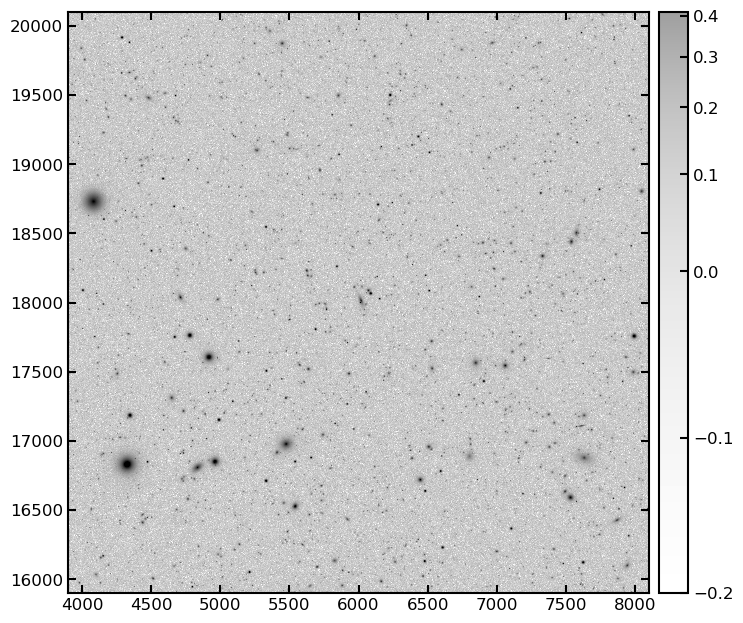

In [23]:
# Create a matplotlib.pyplot figure
fig, ax = plt.subplots()

# Define a colormap
afwDisplay.Display.setDefaultImageColormap('binary')

# Get an alias to the lsst.afw.display.Display() method
display = afwDisplay.Display(frame=fig)

# Set the image stretch algorithm and range
display.scale('asinh', 'zscale')

# Load the image into the display
display.mtv(coadd_calexp.image)

#plt.subplot(projection=WCS(coadd_calexp.getWcs().getFitsMetadata()))
plt.show()
# Clean up memory
remove_figure(fig)

In [24]:
# Get pixel coordinates of the Supernova
RaDec = geom.SpherePoint(targ_coord.ra.degree,targ_coord.dec.degree,geom.degrees)

In [25]:
# First, we need to extract the WCS solution, which provides the mapping
#   between XY pixel values and sky coordinates:
wcs = coadd_calexp.getWcs()

# Print the WCS info to see what it contains:
print(wcs)

FITS standard SkyWcs:
Sky Origin: (54.5971563981, -30.4958677686)
Pixel Origin: (13999, 13999)
Pixel Scale: 0.2 arcsec/pixel


In [26]:
source_xy = geom.Point2I(wcs.skyToPixel(RaDec))

In [27]:
# Coordinates of all candidate galaxies

gal_ra = DF['ra'].values[s][order]*u.deg
gal_dec = DF['dec'].values[s][order]*u.deg

gal_xy = []
for source in range(len(gal_ra)):
    source_coord = SkyCoord(ra=gal_ra[source],dec=gal_dec[source])
    RaDec = geom.SpherePoint(source_coord.ra.degree,source_coord.dec.degree,geom.degrees)
    gal_xy.append(geom.Point2I(wcs.skyToPixel(RaDec)))

In [35]:
# We will use the function definted in Section 0.
ra, dec = targ_coord.ra.degree, targ_coord.dec.degree
cutout_image = cutout_coadd(butler, ra, dec, datasetType='deepCoadd',
                            cutoutSideLength=200)
print("The size of the cutout in pixels is: ", cutout_image.image.array.shape)

The size of the cutout in pixels is:  (200, 200)


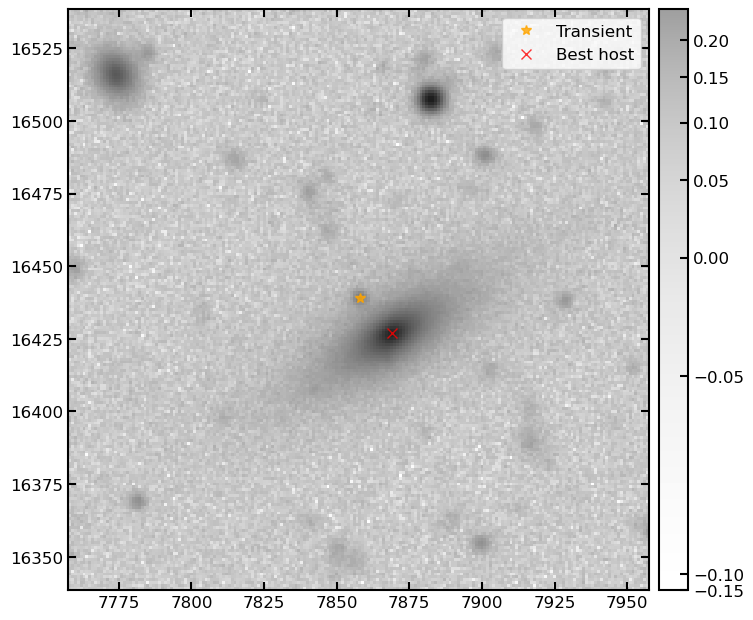

In [36]:
fig, ax = plt.subplots()
afwDisplay.Display.setDefaultImageColormap('binary')
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(cutout_image.image)

plt.plot(source_xy[0],source_xy[1],'*',ms=7, alpha=0.8, color='orange',label='Transient')
plt.plot(gal_xy[0][0],gal_xy[0][1],'x',ms=7,alpha=0.8, color='red',label='Best host')
#ax.axis('off')
plt.legend()
plt.show()
remove_figure(fig)